<a href="https://www.kaggle.com/code/dalloliogm/submission-ensemble?scriptVersionId=240052332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Set your folder
submission_folder = "/kaggle/input/elucidata-submissions"

# Extract predictions and scores
pattern = re.compile(r"submission_(\d+)\.csv")
predictions = []
weights = []
submission_names = []

for fname in os.listdir(submission_folder):
    match = pattern.match(fname)
    if not match:
        continue
    score_str = match.group(1)
    score = float("0." + score_str.lstrip("0"))
    df = pd.read_csv(os.path.join(submission_folder, fname))
    pred_cols = [col for col in df.columns if col != "ID"]
    predictions.append(df[pred_cols].copy())
    weights.append(score)
    submission_names.append(fname)

# Shape: (N, C, M)
pred_array = np.stack([df.values for df in predictions], axis=-1)
weights = np.array(weights)
weights = weights / weights.sum()
n_samples, n_targets, n_models = pred_array.shape
ID = df["ID"]
columns = predictions[0].columns

# === 1. Nonlinear Weighted Averaging (Power Weighting) ===
power = 3
w_pow = weights**power
w_pow = w_pow / w_pow.sum()
ensemble_power = np.average(pred_array, axis=-1, weights=w_pow)
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_power.T))}).to_csv("ensemble_power_weighted.csv", index=False)

# === 2. Top-k Averaging ===
k = 3
top_k_idx = np.argsort(weights)[-k:]
top_k_preds = pred_array[:, :, top_k_idx]
top_k_weights = weights[top_k_idx] / weights[top_k_idx].sum()
ensemble_top_k = np.average(top_k_preds, axis=-1, weights=top_k_weights)
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_top_k.T))}).to_csv("ensemble_top_k.csv", index=False)

# === 3. Blended Ensemble: Best Model + Others (80/20) ===
best_idx = np.argmax(weights)
best_model = pred_array[:, :, best_idx]
others = np.delete(pred_array, best_idx, axis=2)
others_avg = np.mean(others, axis=2)
alpha = 0.8
ensemble_blend = alpha * best_model + (1 - alpha) * others_avg
pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_blend.T))}).to_csv("ensemble_blend_best_avg.csv", index=False)

# === 4. Threshold-Based Ensemble (Score ≥ 0.3) ===
threshold = 0.3
mask = weights >= threshold
if mask.sum() == 0:
    print("⚠️ No models passed the threshold. Skipping this ensemble.")
else:
    selected_preds = pred_array[:, :, mask]
    selected_weights = weights[mask] / weights[mask].sum()
    ensemble_thresh = np.average(selected_preds, axis=-1, weights=selected_weights)
    pd.DataFrame({"ID": ID, **dict(zip(columns, ensemble_thresh.T))}).to_csv("ensemble_threshold_0.3.csv", index=False)

print("✅ Saved ensemble files:")
print("- ensemble_power_weighted.csv")
print("- ensemble_top_k.csv")
print("- ensemble_blend_best_avg.csv")
if mask.sum() > 0:
    print("- ensemble_threshold_0.3.csv")


⚠️ No models passed the threshold. Skipping this ensemble.
✅ Saved ensemble files:
- ensemble_power_weighted.csv
- ensemble_top_k.csv
- ensemble_blend_best_avg.csv


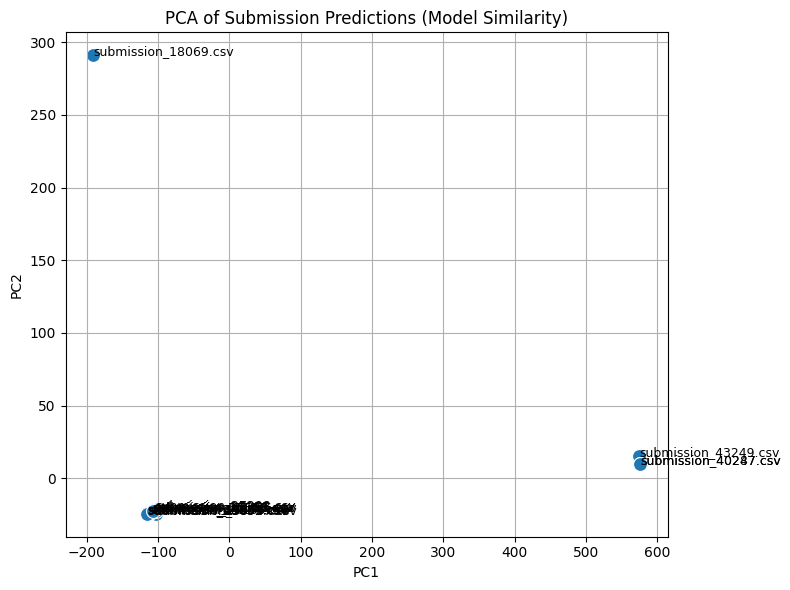

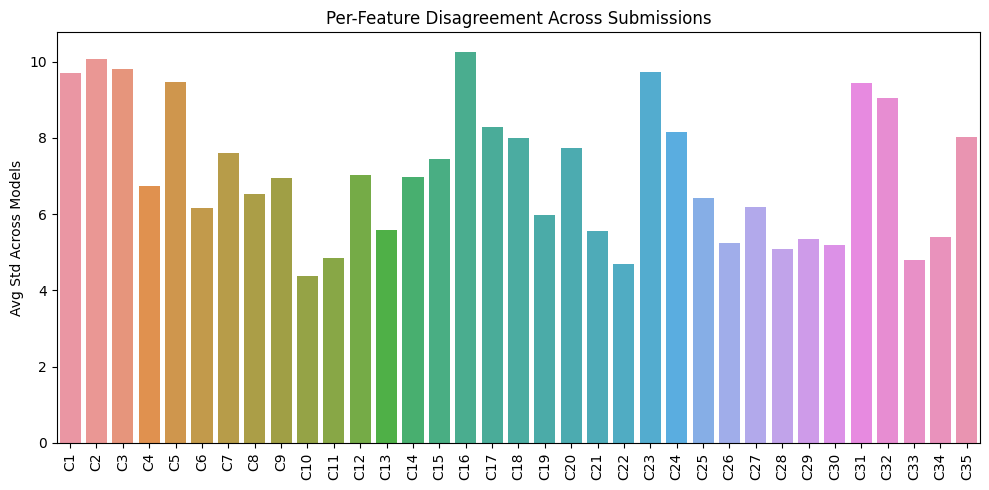

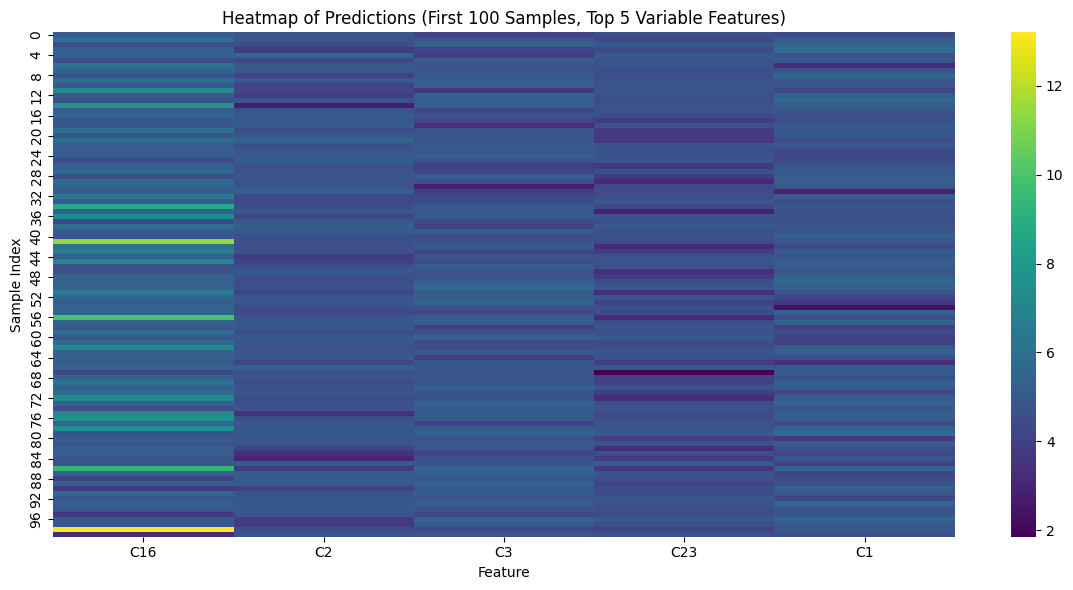

In [2]:
# ======================
# 🔍 Visualizations
# ======================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# -------- 1. PCA across submissions (model similarity) --------
# Flatten each submission (N samples * C features) for PCA
submission_vectors = [df.values.flatten() for df in predictions]
submission_matrix = np.stack(submission_vectors)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(StandardScaler().fit_transform(submission_matrix))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=100)
for i, name in enumerate(submission_names):
    plt.text(pca_result[i, 0], pca_result[i, 1], name, fontsize=9)
plt.title("PCA of Submission Predictions (Model Similarity)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- 2. Concordance per prediction target (feature agreement) --------
# Compute std across models for each (sample, feature), then average over samples
feature_std = np.std(pred_array, axis=-1)  # shape: (N, C)
feature_disagreement = np.mean(feature_std, axis=0)  # shape: (C,)

plt.figure(figsize=(10, 5))
sns.barplot(x=predictions[0].columns, y=feature_disagreement)
plt.xticks(rotation=90)
plt.ylabel("Avg Std Across Models")
plt.title("Per-Feature Disagreement Across Submissions")
plt.tight_layout()
plt.show()

# -------- 3. Heatmap of first 100 samples across top 5 features --------
# Pick top 5 variable features
top_features = np.argsort(-feature_disagreement)[:5]
sample_subset = pred_array[:100, top_features, :]  # shape: (100, 5, M)
avg_preds = sample_subset.mean(axis=-1)  # shape: (100, 5)

plt.figure(figsize=(12, 6))
sns.heatmap(avg_preds, xticklabels=[predictions[0].columns[i] for i in top_features], cmap="viridis")
plt.title("Heatmap of Predictions (First 100 Samples, Top 5 Variable Features)")
plt.xlabel("Feature")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

